# Knox statistic

Here we'll compute the knox statistic and p-values for the South Side of Chicago Burglary data.

We'll follow the methodology of

2. Johnson, S.D., Bernasco, W., Bowers, K.J. et al. "Space–Time Patterns of Risk: A Cross National Assessment of Residential Burglary Victimization", J Quant Criminol (2007) 23: 201. doi:10.1007/s10940-007-9025-3



In [1]:
%matplotlib inline
from common import *
datadir = os.path.join("//media", "disk", "Data")
south_side, points = load_data(datadir)

In [2]:
import open_cp.knox

In [8]:
knox = open_cp.knox.Knox()
knox.set_time_bins([(i*7,i*7+7) for i in range(10)], unit="days")
knox.space_bins = list( (i*100,i*100+100) for i in range(20) )
knox.data = points
result = knox.calculate()

In [9]:
def knox_ratio(statistic, distribution):
    """As in the paper, compute the ratio of the statistic to the median
    of the values in the distribution"""
    d = np.array(distribution)
    d.sort()
    return statistic / d[len(d)//2]

## Produce a plot as in the paper.

In [10]:
cdict = {'red':   [(0.0,  1.0, 1.0),
                   (1.0,  1.0, 1.0)],

         'green': [(0.0,  1.0, 1.0),
                   (1.0,  0.0, 0.0)],

         'blue':  [(0.0,  0.2, 0.2),
                   (1.0,  0.2, 0.2)]}
my_cmap = matplotlib.colors.LinearSegmentedColormap("mycmap", cdict)
mappable = plt.cm.ScalarMappable(cmap=my_cmap)

def all_ratios(result):
    for i, space_bin in enumerate(result.space_bins):
        for j, time_bin in enumerate(result.time_bins):
            yield knox_ratio(result.statistic(i,j), result.distribution(i,j))
            
mappable.set_array(list(all_ratios(result)))
mappable.autoscale()

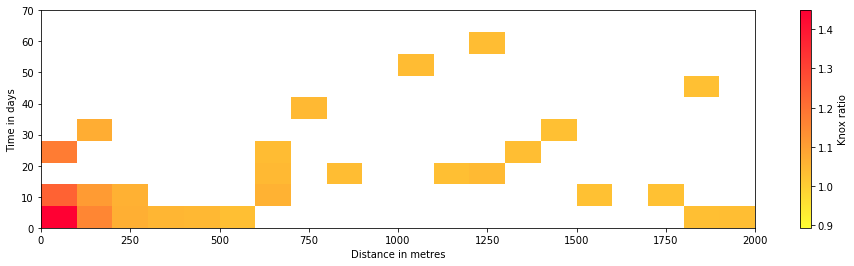

In [11]:
fig, ax = plt.subplots(figsize=(16,4))

xmin = min(x for x,y in result.space_bins)
xmax = max(y for x,y in result.space_bins)
ax.set(xlim=(xmin, xmax), xlabel="Distance in metres")

_day = np.timedelta64(1,"D")
ymin = min(t / _day for t,s in result.time_bins)
ymax = max(s / _day for t,s in result.time_bins)
ax.set(ylim=(ymin, ymax), ylabel="Time in days")

for i, space_bin in enumerate(result.space_bins):
    for j, time_bin in enumerate(result.time_bins):
        if result.pvalue(i,j) >= 0.05:
            continue
        ratio = knox_ratio(result.statistic(i,j), result.distribution(i,j))
        x, y = space_bin[0], time_bin[0] / _day
        width = space_bin[1] - space_bin[0]
        height = (time_bin[1] - time_bin[0]) / _day
        p = matplotlib.patches.Rectangle((x,y), width, height, fc=mappable.to_rgba(ratio))
        ax.add_patch(p)
        
cbar = fig.colorbar(mappable, orientation="vertical")
cbar.set_label("Knox ratio")

## Distribution in a couple of cases

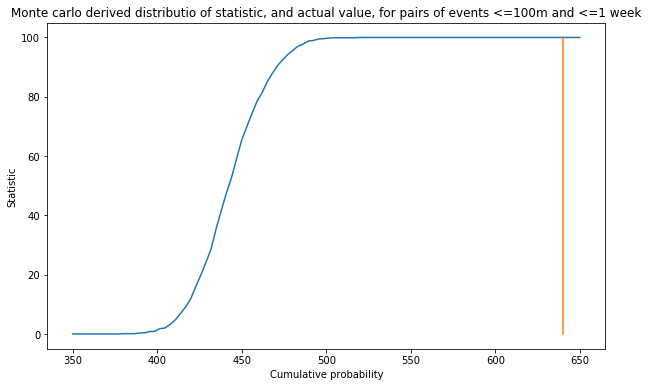

In [24]:
fig, ax = plt.subplots(figsize=(10,6))

d = np.array(result.distribution(0,0))
d.sort()

x = np.linspace(350, 650, 100)
y = [ np.sum(d <= xx) / len(d) * 100 for xx in x ]
ax.plot(x,y)

a = result.statistic(0,0)

ax.plot([a,a], [0, 100])
ax.set(xlabel="Cumulative probability", ylabel="Statistic")
ax.set_title("Monte carlo derived distributio of statistic, and actual value, for pairs of events <=100m and <=1 week")
None